# Tutorial

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
import regvelo
from regvelo import REGVELOVI,sanity_check,prior_GRN,abundance_test,TFscreening
from velovi import preprocess_data
import cellrank as cr

import mplscience
import anndata
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import cdist

## Load datasets

In [2]:
adata = regvelo.datasets.zebrafish_nc()
prior_net = regvelo.datasets.zebrafish_grn()
TF_list = adata.var_names[adata.var["is_tf"]].tolist()

100%|██████████| 40.2M/40.2M [00:00<00:00, 107MB/s] 


In [3]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
scv.pp.moments(adata)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


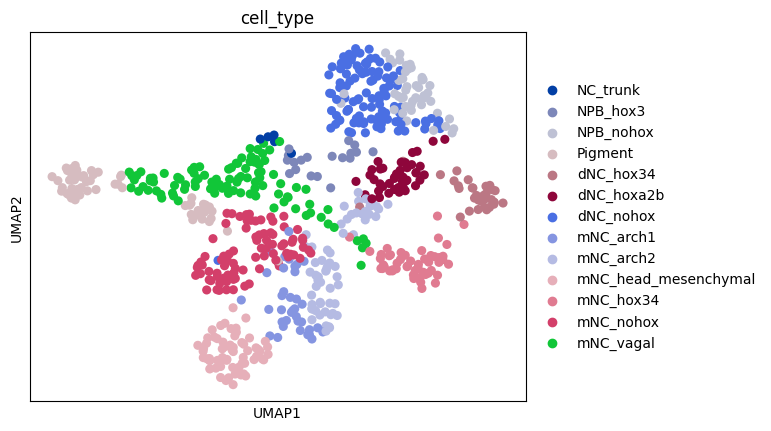

In [4]:
sc.pl.umap(adata, color='cell_type')

## Preprocessing

In [5]:
adata = preprocess_data(adata)
adata = prior_GRN(adata,prior_net)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [6]:
TF_list = set(TF_list).intersection(adata.var_names)
TF_list = list(TF_list)
print("final number of TF: "+str(len(TF_list)))

final number of TF: 80


In [7]:
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W))

In [8]:
sparsity = W.sum() / ((W.sum(1) != 0).sum() * W.shape[0])
print("network sparsity: "+str(np.array(sparsity)))

network sparsity: 0.05279029


## Trainining RegVelo model

In [9]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(adata,W=W.T,regulators = TF_list,soft_constraint = False)

In [10]:
reg_vae.train()

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Epoch 1500/1500: 100%|██████████| 1500/1500 [11:23<00:00,  2.38it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1500/1500: 100%|██████████| 1500/1500 [11:23<00:00,  2.19it/s, v_num=1]


In [11]:
reg_vae.save("rgv_model")

In [12]:
adata_target = reg_vae.add_regvelo_outputs_to_adata(adata = adata)

In [13]:
scv.tl.velocity_graph(adata_target)

computing velocity graph (using 1/128 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## Predict terminal states

100%|██████████| 697/697 [00:00<00:00, 1930.25cell/s]


Defaulting to `'gmres'` solver.


100%|██████████| 4/4 [00:00<00:00, 62.99/s]


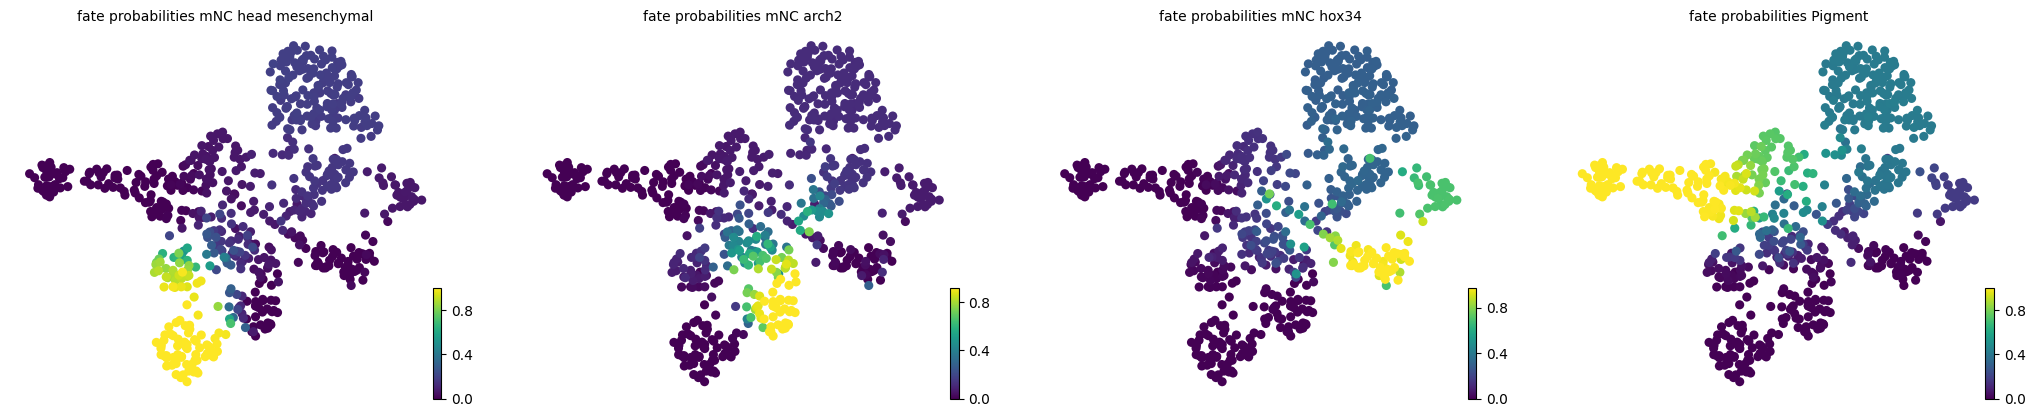

In [14]:
terminal_states = [
        "mNC_head_mesenchymal",
        "mNC_arch2",
        "mNC_hox34",
        "Pigment",
    ]
vk = cr.kernels.VelocityKernel(adata_target)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_target).compute_transition_matrix()
g_raw = cr.estimators.GPCCA(vk)
## evaluate the fate prob on original space
g_raw.compute_macrostates(n_states=8,cluster_key="cell_type")
g_raw.set_terminal_states(terminal_states)
g_raw.compute_fate_probabilities()
g_raw.plot_fate_probabilities(same_plot=False)

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


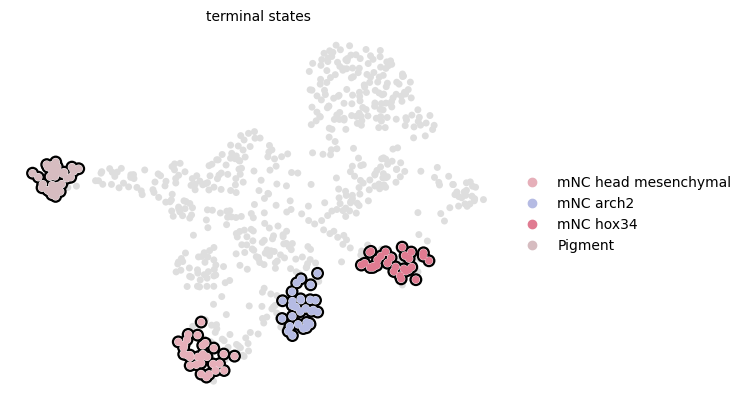

In [15]:
g_raw.plot_macrostates(which="terminal", legend_loc="right", s=100)

## Perform perturbation screening

In [16]:
fate_prob_perturb = []
cand_list = ["nr2f5","sox9b","twist1a","twist1b","sox10","mitfa","tfec","tfap2a","tfap2b"]
for TF in cand_list:
    model = 'rgv_model'
    adata_target_perturb,reg_vae_perturb =  regvelo.in_silico_block_simulation(model,adata,TF)
    ### predict the terminal state dfference
    n_states = 8
    vk = cr.kernels.VelocityKernel(adata_target_perturb)
    vk.compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata_target_perturb).compute_transition_matrix()
    g = cr.estimators.GPCCA(vk)
    ## evaluate the fate prob on original space
    g.compute_macrostates(n_states=n_states,cluster_key="cell_type")
    g.set_terminal_states(terminal_states)
    g.compute_fate_probabilities()
    ## visualize coefficient
    cond1_df = pd.DataFrame(adata_target_perturb.obsm["lineages_fwd"], columns=adata_target_perturb.obsm["lineages_fwd"].names.tolist())

    fate_prob_perturb.append(cond1_df)

INFO     File rgv_model/model.pt already downloaded                                                                


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
100%|██████████| 697/697 [00:00<00:00, 2063.35cell/s]


100%|██████████| 4/4 [00:00<00:00, 73.47/s]

INFO     File rgv_model/model.pt already downloaded                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
100%|██████████| 697/697 [00:00<00:00, 2272.54cell/s]


100%|██████████| 4/4 [00:00<00:00, 74.22/s]

INFO     File rgv_model/model.pt already downloaded                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
100%|██████████| 697/697 [00:00<00:00, 2097.03cell/s]


100%|██████████| 4/4 [00:00<00:00, 72.59/s]

INFO     File rgv_model/model.pt already downloaded                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
100%|██████████| 697/697 [00:00<00:00, 2212.65cell/s]


100%|██████████| 4/4 [00:00<00:00, 73.36/s]

INFO     File rgv_model/model.pt already downloaded                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
100%|██████████| 697/697 [00:00<00:00, 2106.53cell/s]


100%|██████████| 4/4 [00:00<00:00, 80.64/s]

INFO     File rgv_model/model.pt already downloaded                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
100%|██████████| 697/697 [00:00<00:00, 2053.99cell/s]


100%|██████████| 4/4 [00:00<00:00, 73.80/s]

INFO     File rgv_model/model.pt already downloaded                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
100%|██████████| 697/697 [00:00<00:00, 2106.44cell/s]


100%|██████████| 4/4 [00:00<00:00, 73.01/s]

INFO     File rgv_model/model.pt already downloaded                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
100%|██████████| 697/697 [00:00<00:00, 2150.89cell/s]


100%|██████████| 4/4 [00:00<00:00, 67.17/s]

INFO     File rgv_model/model.pt already downloaded                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
100%|██████████| 697/697 [00:00<00:00, 2176.36cell/s]


100%|██████████| 4/4 [00:00<00:00, 61.72/s]


In [17]:
cond2_df = pd.DataFrame(adata_target.obsm["lineages_fwd"], columns=adata_target.obsm["lineages_fwd"].names.tolist())
df_list = []
for i in range(len(fate_prob_perturb)):
    #data = np.array(((fate_prob_perturb[i]+1) - (cond2_df+1)))
    data = abundance_test(cond2_df, fate_prob_perturb[i])
    data = pd.DataFrame({"Score": data.iloc[:,0].tolist(),
                     "Terminal state": data.index.tolist(),
                     "TF":[cand_list[i]]*(data.shape[0])})
    df_list.append(data)

In [18]:
df = pd.concat(df_list)

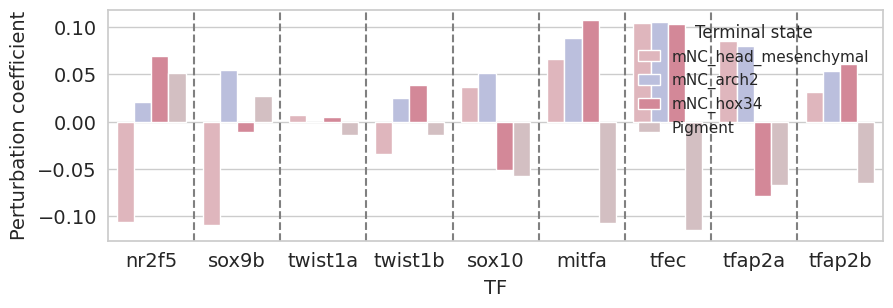

In [19]:
with mplscience.style_context():
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10,3))
    #sns.barplot(x='Terminal state', y='AUROC',data=data, hue = "Method",palette=pal,ax = ax)
    color_label = "cell_type"
    palette = dict(zip(adata.obs[color_label].cat.categories, adata.uns[f"{color_label}_colors"]))
    subset_palette = {name: color for name, color in palette.items() if name in cond2_df.columns.tolist()}

    sns.barplot(x='TF', y='Score', hue='Terminal state', data=df, ax=ax, palette=palette, dodge=True)

    # Add vertical lines to separate groups
    for i in range(len(df['TF'].unique()) - 1):
        plt.axvline(x=i + 0.5, color='gray', linestyle='--')

    # Label settings
    plt.ylabel('Perturbation coefficient', fontsize=14)
    plt.xlabel('TF', fontsize=14)
    plt.xticks(fontsize=14)  # Increase font size of x-axis tick labels
    plt.yticks(fontsize=14)  # Increase font size of y-axis tick labels
    plt.show()

## Screening different KO combination

In [20]:
KO_list = ["tfec","mitfa","fli1a_sox9b","nr2f5"]
perturb_coef,perturb_pval = TFscreening(adata = adata,
            prior_graph = W.T,
            soft_constraint = False,
            TF_list = TF,
            cluster_label = "cell_type",
            terminal_states = terminal_states,
            KO_list = KO_list,
            n_states = 8,
            cutoff = 0)

training model...


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Epoch 1122/1500:  75%|███████▍  | 1122/1500 [08:25<02:50,  2.22it/s, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2406.811. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File /ictstr01/home/icb/weixu.wang/rgv_test/perturb_repeat_runs/rgv_model_0/model.pt already downloaded   


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
100%|██████████| 697/697 [00:00<00:00, 1272.59cell/s]


100%|██████████| 4/4 [00:00<00:00, 52.89/s]

INFO     File /ictstr01/home/icb/weixu.wang/rgv_test/perturb_repeat_runs/rgv_model_0/model.pt already downloaded   



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
100%|██████████| 697/697 [00:00<00:00, 2154.83cell/s]


100%|██████████| 4/4 [00:00<00:00, 76.64/s]


Done tfec
INFO     File /ictstr01/home/icb/weixu.wang/rgv_test/perturb_repeat_runs/rgv_model_0/model.pt already downloaded   


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
100%|██████████| 697/697 [00:00<00:00, 2125.97cell/s]


100%|██████████| 4/4 [00:00<00:00, 74.13/s]

Done mitfa
INFO     File /ictstr01/home/icb/weixu.wang/rgv_test/perturb_repeat_runs/rgv_model_0/model.pt already downloaded   



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
100%|██████████| 697/697 [00:00<00:00, 2139.31cell/s]


100%|██████████| 4/4 [00:00<00:00, 70.21/s]

Done fli1a_sox9b
INFO     File /ictstr01/home/icb/weixu.wang/rgv_test/perturb_repeat_runs/rgv_model_0/model.pt already downloaded   



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
100%|██████████| 697/697 [00:00<00:00, 2116.27cell/s]


100%|██████████| 4/4 [00:00<00:00, 69.55/s]


Done nr2f5


In [21]:
perturb_coef

,mNC_head_mesenchymal,mNC_arch2,mNC_hox34,Pigment
fli1a_sox9b,-0.161397,-0.051635,0.105049,0.049476
mitfa,0.066319,0.094888,0.106523,-0.100716
nr2f5,-0.105581,0.041670,0.061565,0.061918
tfec,0.112809,0.122746,0.116664,-0.121007
